# New EDA

## 1. setting modules

In [117]:
# load modules
import numpy as np
import pandas as pd
import geopandas as gpd
import tqdm
import random
import os

# split
from sklearn.model_selection import train_test_split

# models 
from xgboost import XGBRegressor, DMatrix
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from supervised.automl import AutoML

# tuning
import optuna

# vif
from statsmodels.stats.outliers_influence import variance_inflation_factor

# visualization
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
import plotly

# metrics
from sklearn.metrics import mean_squared_log_error

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# ttest
import scipy.stats as stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline

In [30]:
# random seed 고정하기
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [31]:
# load data
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
add = pd.read_csv('../Data/another_factor.csv', encoding = 'cp949')

In [32]:
# 필요한 데이터만 가져오기
use_train = train[['사고일시', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '시군구', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO']]
use_test = test[test.columns.difference(['ID'])]

## 2. data preprocessing

In [33]:
# 요일 월~금: 0 토~일:1
# use_train['주말'] = np.where(use_train['요일'].isin(['월요일', '화요일', '수요일', '목요일', '금요일']), 0, 1)
# use_test['주말'] = np.where(use_test['요일'].isin(['월요일', '화요일', '수요일', '목요일', '금요일']), 0, 1)

In [34]:
## date type data
use_train['사고일시'] = pd.to_datetime(use_train['사고일시'])
use_test['사고일시'] = pd.to_datetime(use_test['사고일시'])

# split year, month, day, hour
use_train['year'] = use_train['사고일시'].dt.year
use_train['month'] = use_train['사고일시'].dt.month
use_train['day'] = use_train['사고일시'].dt.day
use_train['hour'] = use_train['사고일시'].dt.hour

use_test['year'] = use_test['사고일시'].dt.year
use_test['month'] = use_test['사고일시'].dt.month
use_test['day'] = use_test['사고일시'].dt.day
use_test['hour'] = use_test['사고일시'].dt.hour

In [35]:
# 시간을 푸리에 변환
use_train['sin_hour'] = np.sin(2 * np.pi * use_train['hour']/23.0)
use_train['cos_hour'] = np.cos(2 * np.pi * use_train['hour']/23.0)
use_test['sin_hour'] = np.sin(2 * np.pi * use_test['hour']/23.0)
use_test['cos_hour'] = np.cos(2 * np.pi * use_test['hour']/23.0)

In [36]:
# 시군구 나누기
use_train[['시', '구', '동가']] = use_train['시군구'].str.split(' ', expand = True)
use_test[['시', '구', '동가']] = use_test['시군구'].str.split(' ', expand = True)

In [37]:
# 도로형태 나누기
use_train[['도로형태1', '도로형태2']] = use_train['도로형태'].str.split(' - ', expand = True)
use_test[['도로형태1', '도로형태2']] = use_test['도로형태'].str.split(' - ', expand = True)

In [38]:
# 계절 추가
def select_criteria(datasetname, monthvaluename):
    cri = [
        (datasetname[monthvaluename].isin([3, 4, 5])),
        (datasetname[monthvaluename].isin([6, 7, 8])),
        (datasetname[monthvaluename].isin([9, 10, 11]))
    ]
    return cri

season = [
    'Spring', 'Summer', 'Fall'
]
use_train['계절'] = np.select(select_criteria(use_train, 'month'), season, default = 'Winter')
use_test['계절'] = np.select(select_criteria(use_test, 'month'), season, default = 'Winter')

In [39]:
# 추가변수 붙여넣기
use_train2 = pd.merge(use_train, add, how = 'left', on = '동가')
use_test2 = pd.merge(use_test, add, how = 'left', on = '동가')

In [40]:
# 결측치는 0으로
use_train2[add.columns] = use_train2[add.columns].fillna(0)
use_test2[add.columns] = use_test2[add.columns].fillna(0)

In [41]:
use_train2.columns

Index(['사고일시', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '시군구', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO', 'year', 'month', 'day', 'hour', 'sin_hour',
       'cos_hour', '시', '구', '동가', '도로형태1', '도로형태2', '계절', '보호구역', '불법주정차',
       '차량전용', '평지도로', '설치개수', '주차장개수', '어린이보호구역개수'],
      dtype='object')

In [42]:
# one hot encoding
onehot = pd.get_dummies(use_train2[['기상상태', '노면상태', '사고유형', '구', '계절', '요일']], drop_first=True)
use_train3 = pd.concat([use_train2, onehot], axis = 1)

onehot_test = pd.get_dummies(use_test2[['기상상태', '노면상태', '사고유형', '구', '계절', '요일']], drop_first=True)
use_test3 = pd.concat([use_test2, onehot_test], axis = 1)

In [43]:
# 안개 없기 때문에 0
use_test3['기상상태_안개'] = 0

In [44]:
# 안쓰는 열 제외
use_train4 = use_train3.drop(['기상상태', '도로형태', '도로형태1', '도로형태2', '노면상태', '사고유형', '구', '도로형태1', '도로형태2', '계절', 'year', 'day', 'month',
                              'hour', '시', '동가', '사고일시', '시군구', '요일'], axis = 1)

use_test4 = use_test3.drop(['기상상태', '도로형태', '도로형태1', '도로형태2', '노면상태', '사고유형', '구', '도로형태1', '도로형태2', '계절', 'year', 'day', 'month',
                              'hour', '시', '동가', '사고일시', '시군구', '요일'], axis = 1)

### =======================

In [45]:
# 도로형태
cri0 = use_train3[['도로형태', 'ECLO']].groupby('도로형태').mean().reset_index()
cri0['도로group'] = np.where(cri0['ECLO'] >= 5, 1, 0)
tmp = pd.merge(use_train3, cri0[['도로group', '도로형태']], how = 'left', on = '도로형태')

In [46]:
t_stat, p_val = stats.ttest_ind(tmp[tmp['도로group'] == 1]['ECLO'], tmp[tmp['도로group'] == 0]['ECLO'], equal_var=True)

In [47]:
p_val

6.394707988530633e-29

In [48]:
t_stat

11.168911576246918

In [112]:
# 사고유형
cri = use_train3[['사고유형', 'ECLO']].groupby('사고유형').mean().reset_index()
cri

,사고유형,ECLO
0,차대사람,3.817650
1,차대차,4.944597
2,차량단독,4.006054


In [116]:
# the "C" indicates categorical data
model = ols("ECLO ~ C(사고유형)", use_train3).fit()

print(anova_lm(model))

               df         sum_sq      mean_sq           F         PR(>F)
C(사고유형)       2.0    7670.376103  3835.188052  379.984155  3.453660e-164
Residual  39606.0  399744.189577    10.093021         NaN            NaN


In [119]:
# tukey hsd
hsd = pairwise_tukeyhsd(use_train3['ECLO'], use_train3['사고유형'], alpha=0.05)
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
차대사람,차대차,1.1269,0.0,1.0277,1.2262,True
차대사람,차량단독,0.1884,0.1887,-0.0647,0.4415,False
차대차,차량단독,-0.9385,0.0,-1.1787,-0.6983,True


In [61]:
# 사고유형
cri = use_train3[['hour', 'ECLO', '사고유형']].groupby(['hour', '사고유형']).mean().reset_index()

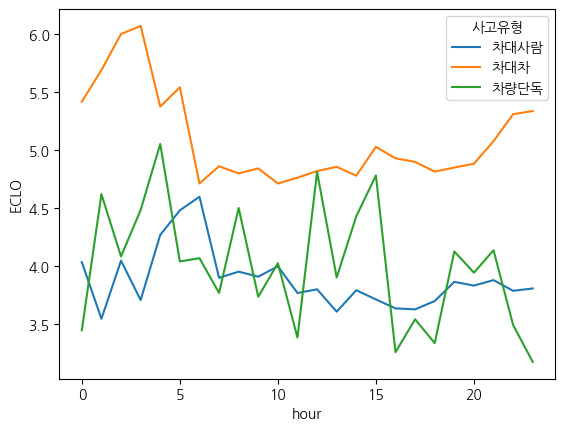

In [63]:
sns.lineplot(data = cri, x='hour', y='ECLO', hue = '사고유형')
plt.show()

In [81]:
# 사고유형
cri2 = use_train3[['요일', 'ECLO', '사고유형']].groupby(['요일', '사고유형']).mean().reset_index()

In [142]:
tmp = use_train3[['사고일시', 'ECLO', '노면상태']].groupby(['사고일시', '노면상태']).mean().reset_index()
tmp

,사고일시,노면상태,ECLO
0,2019-01-01 00:00:00,건조,4.0
1,2019-01-01 01:00:00,건조,3.0
2,2019-01-01 02:00:00,건조,5.0
3,2019-01-01 04:00:00,건조,4.5
4,2019-01-01 05:00:00,건조,18.0
...,...,...,...
18992,2021-12-31 18:00:00,건조,5.2
18993,2021-12-31 19:00:00,건조,3.0
18994,2021-12-31 21:00:00,건조,10.0
18995,2021-12-31 22:00:00,건조,3.0


In [148]:
tmp[tmp['노면상태'] == '침수']

,사고일시,노면상태,ECLO
10873,2020-09-02 21:00:00,침수,10.0
16126,2021-07-10 19:00:00,침수,1.0
16866,2021-08-24 10:00:00,침수,6.0


In [150]:
use_test[use_test['노면상태'] == '침수']

,기상상태,노면상태,도로형태,사고유형,사고일시,시군구,요일,year,month,day,hour,sin_hour,cos_hour,시,구,동가,도로형태1,도로형태2,계절
3241,비,침수,교차로 - 교차로부근,차대차,2022-04-29 05:00:00,대구광역시 서구 비산동,금요일,2022,4,29,5,0.979084,0.203456,대구광역시,서구,비산동,교차로,교차로부근,Spring
5513,맑음,침수,교차로 - 교차로부근,차량단독,2022-07-07 13:00:00,대구광역시 달성군 논공읍,목요일,2022,7,7,13,-0.398401,-0.917211,대구광역시,달성군,논공읍,교차로,교차로부근,Summer


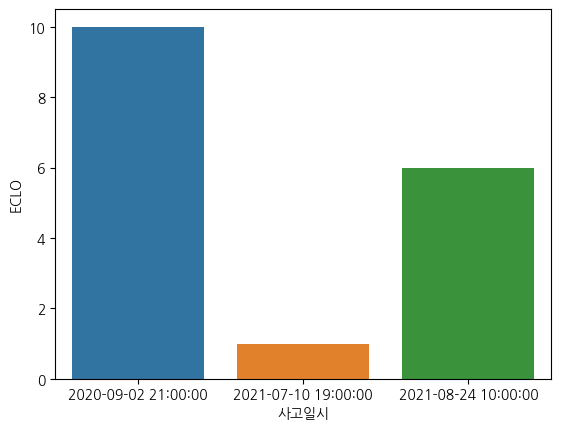

In [147]:
sns.barplot(data = tmp[tmp['노면상태'] == '침수'], x='사고일시', y='ECLO')
plt.show()

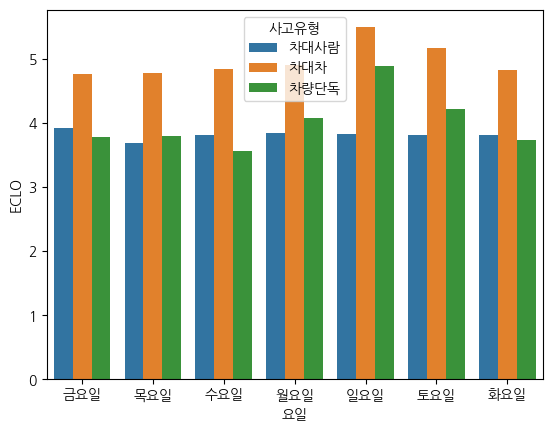

In [73]:
sns.barplot(data = cri2, x='요일', y='ECLO', hue = '사고유형')
plt.show()

<Axes: xlabel='불법주정차', ylabel='ECLO'>

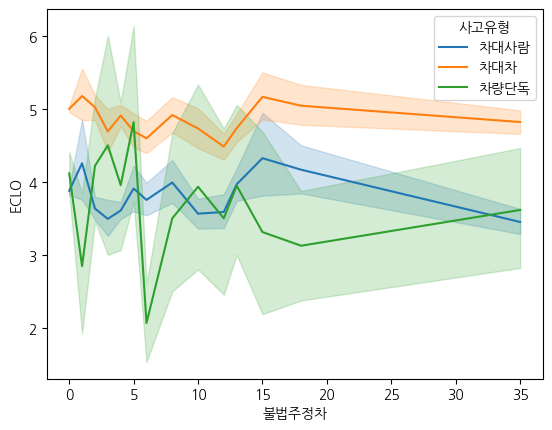

In [130]:
sns.lineplot(data = use_train3, x='불법주정차', y='ECLO', hue = '사고유형')

<Axes: xlabel='차량전용', ylabel='ECLO'>

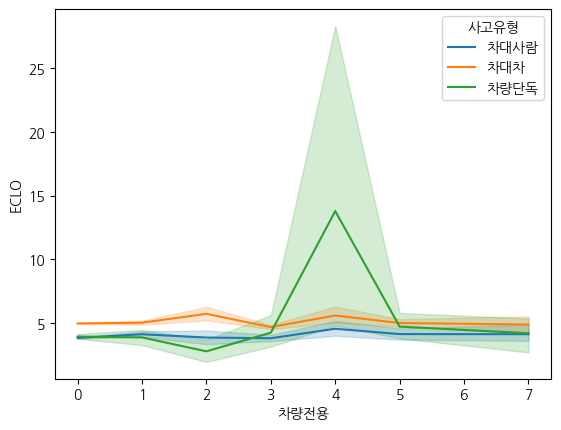

In [129]:
sns.lineplot(data = use_train3, x='차량전용', y='ECLO', hue = '사고유형')

<Axes: xlabel='어린이보호구역개수', ylabel='ECLO'>

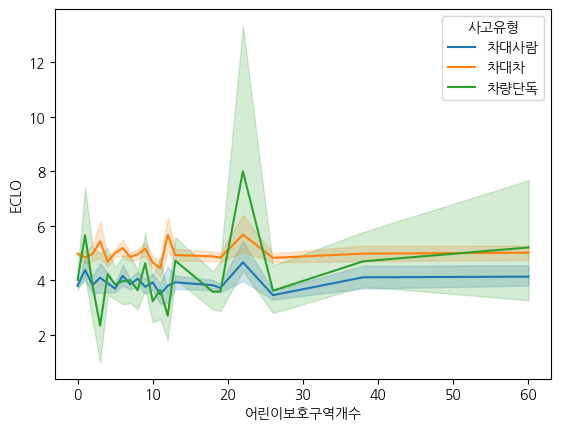

In [128]:
sns.lineplot(data = use_train3, x='어린이보호구역개수', y='ECLO', hue = '사고유형')

<Axes: xlabel='주차장개수', ylabel='ECLO'>

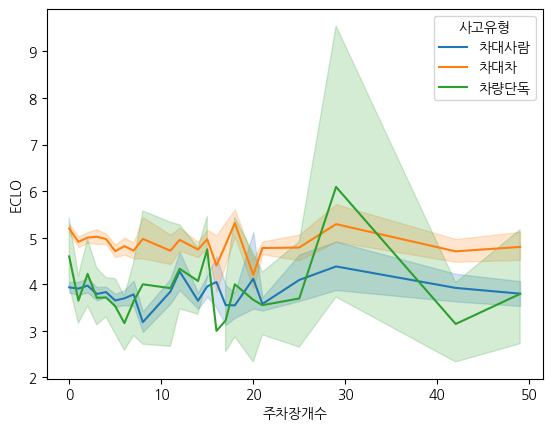

In [131]:
sns.lineplot(data = use_train3, x='주차장개수', y='ECLO', hue = '사고유형')

<Axes: xlabel='설치개수', ylabel='ECLO'>

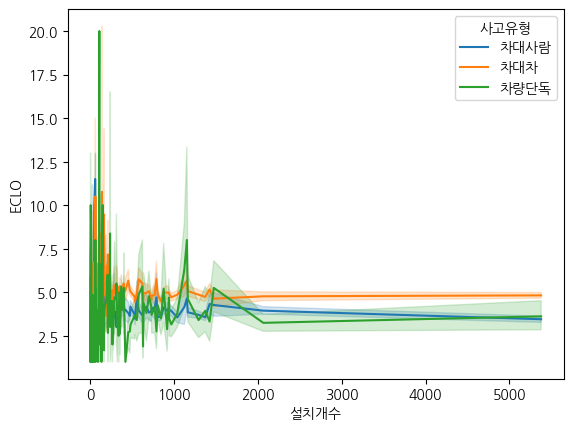

In [132]:
sns.lineplot(data = use_train3, x='설치개수', y='ECLO', hue = '사고유형')

<Axes: xlabel='평지도로', ylabel='ECLO'>

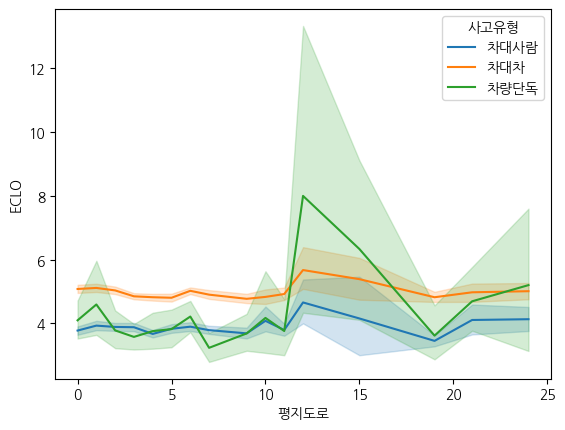

In [133]:
sns.lineplot(data = use_train3, x='평지도로', y='ECLO', hue = '사고유형')

<Axes: xlabel='보호구역', ylabel='ECLO'>

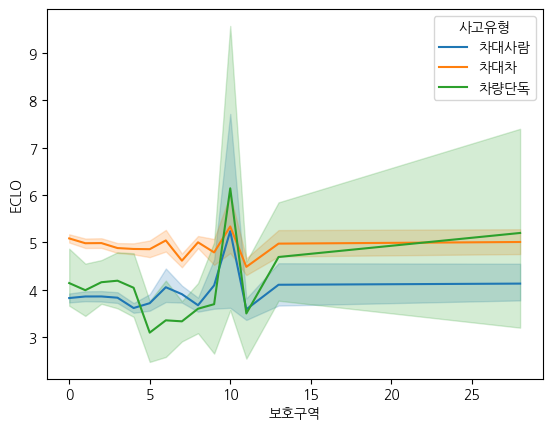

In [134]:
sns.lineplot(data = use_train3, x='보호구역', y='ECLO', hue = '사고유형')

In [122]:
use_train3.columns

Index(['사고일시', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '시군구', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO', 'year', 'month', 'day', 'hour', 'sin_hour',
       'cos_hour', '시', '구', '동가', '도로형태1', '도로형태2', '계절', '보호구역', '불법주정차',
       '차량전용', '평지도로', '설치개수', '주차장개수', '어린이보호구역개수', '기상상태_눈', '기상상태_맑음',
       '기상상태_비', '기상상태_안개', '기상상태_흐림', '노면상태_기타', '노면상태_서리/결빙', '노면상태_적설',
       '노면상태_젖음/습기', '노면상태_침수', '사고유형_차대차', '사고유형_차량단독', '구_달서구', '구_달성군',
       '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '계절_Spring', '계절_Summer',
       '계절_Winter', '요일_목요일', '요일_수요일', '요일_월요일', '요일_일요일', '요일_토요일',
       '요일_화요일'],
      dtype='object')

In [82]:
# 기상상태, 노면상태
cri3 = use_train3[['기상상태', 'ECLO', '노면상태']].groupby(['기상상태', '노면상태']).mean().reset_index()

<Axes: xlabel='노면상태', ylabel='ECLO'>

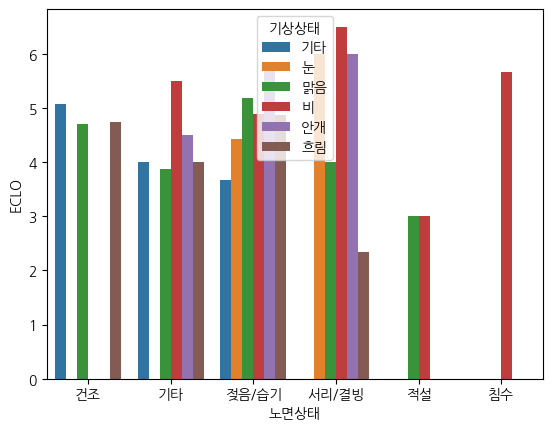

In [86]:
sns.barplot(data = cri3, x = '노면상태', y= 'ECLO', hue = '기상상태')

In [88]:
use_train2.columns

Index(['사고일시', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '시군구', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO', 'year', 'month', 'day', 'hour', 'sin_hour',
       'cos_hour', '시', '구', '동가', '도로형태1', '도로형태2', '계절', '보호구역', '불법주정차',
       '차량전용', '평지도로', '설치개수', '주차장개수', '어린이보호구역개수'],
      dtype='object')

In [89]:
# 기상상태, 사고유형
cri4 = use_train3[['기상상태', 'ECLO', '사고유형']].groupby(['기상상태', '사고유형']).mean().reset_index()

<Axes: xlabel='기상상태', ylabel='ECLO'>

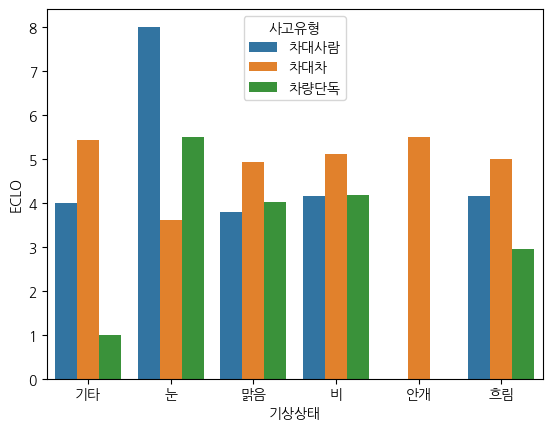

In [94]:
sns.barplot(data = cri4, x = '기상상태', y= 'ECLO', hue = '사고유형')

In [91]:
# 노면상태, 사고유형
cri5 = use_train3[['노면상태', 'ECLO', '사고유형']].groupby(['노면상태', '사고유형']).mean().reset_index()

<Axes: xlabel='노면상태', ylabel='ECLO'>

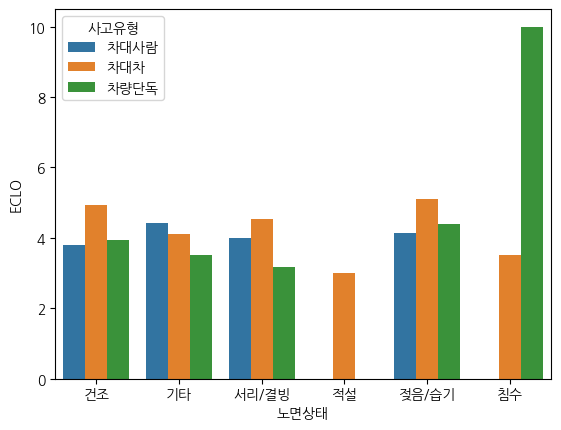

In [93]:
sns.barplot(data = cri5, x = '노면상태', y= 'ECLO', hue = '사고유형')

In [103]:
use_train3.columns

Index(['사고일시', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '시군구', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO', 'year', 'month', 'day', 'hour', 'sin_hour',
       'cos_hour', '시', '구', '동가', '도로형태1', '도로형태2', '계절', '보호구역', '불법주정차',
       '차량전용', '평지도로', '설치개수', '주차장개수', '어린이보호구역개수', '기상상태_눈', '기상상태_맑음',
       '기상상태_비', '기상상태_안개', '기상상태_흐림', '노면상태_기타', '노면상태_서리/결빙', '노면상태_적설',
       '노면상태_젖음/습기', '노면상태_침수', '사고유형_차대차', '사고유형_차량단독', '구_달서구', '구_달성군',
       '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '계절_Spring', '계절_Summer',
       '계절_Winter', '요일_목요일', '요일_수요일', '요일_월요일', '요일_일요일', '요일_토요일',
       '요일_화요일'],
      dtype='object')

In [105]:
# 도로형태, 사고유형
cri7 = use_train3[['도로형태', 'ECLO', '사고유형']].groupby(['도로형태', '사고유형']).mean().reset_index()

<Axes: xlabel='ECLO', ylabel='도로형태'>

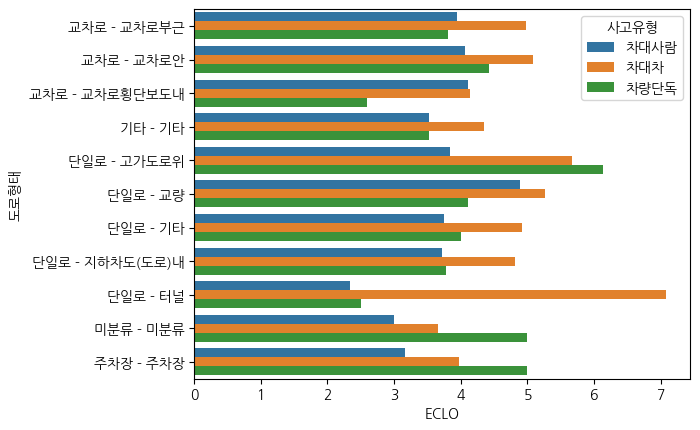

In [107]:
sns.barplot(data = cri7, x = 'ECLO', y= '도로형태', hue = '사고유형')

In [108]:
use_train3['사고유형'].value_counts()

사고유형
차대차     31785
차대사람     6833
차량단독      991
Name: count, dtype: int64

In [109]:
use_test3['사고유형'].value_counts()

사고유형
차대차     8559
차대사람    2079
차량단독     325
Name: count, dtype: int64

In [151]:
use_train3['노면상태'].value_counts()

노면상태
건조       36420
젖음/습기     3100
기타          58
서리/결빙       25
침수           3
적설           3
Name: count, dtype: int64

In [152]:
use_test3['노면상태'].value_counts()

노면상태
건조       10394
젖음/습기      524
기타          35
서리/결빙        7
침수           2
적설           1
Name: count, dtype: int64

In [153]:
use_train3['기상상태'].value_counts()

기상상태
맑음    36181
비      2627
흐림      729
기타       56
안개        8
눈         8
Name: count, dtype: int64

In [154]:
use_test3['기상상태'].value_counts()

기상상태
맑음    10321
비       394
흐림      207
기타       31
눈        10
Name: count, dtype: int64

In [155]:
use_train.columns

Index(['사고일시', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '시군구', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO', 'year', 'month', 'day', 'hour', 'sin_hour',
       'cos_hour', '시', '구', '동가', '도로형태1', '도로형태2', '계절'],
      dtype='object')